In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df_TD4 = pd.read_excel("Dataset TD4.xlsx")

In [4]:
df_TD4
df = df_TD4
df = df.rename(columns={
    "transaction date (1=1day=24 hours)": "t",
    "bid-ask spread": "spread",
    "volume of the transaction (if known)": "volume",
    "Sign of the transaction": "sign",
    "Price (before transaction)": "price"
})

df.sort_values(by = "t", inplace = True)

df["t_bin"] = (df["t"] // 0.01) * 0.01
df["t_bin"] = df["t_bin"].round(2)
df_grouped = df.groupby("t_bin").agg({
    "spread": "last", 
    "volume": "last",
    "sign": "last",
    "price": "last"
}).reset_index()
df_TD4

df

,t,spread,volume,sign,price,t_bin
0,0.000202,0.1100,8.0,-1,100.000,0.00
1,0.001070,0.1030,NaN,1,99.984,0.00
2,0.001496,0.1015,NaN,-1,100.029,0.00
3,0.003336,0.0920,NaN,1,99.979,0.00
4,0.003952,0.1106,NaN,1,100.060,0.00
...,...,...,...,...,...,...
996,0.981441,0.0834,79.0,1,101.070,0.98
997,0.981875,0.1010,NaN,-1,101.120,0.98
998,0.986784,0.1007,NaN,-1,100.998,0.98
999,0.991232,0.1153,3.0,-1,100.958,0.99


In [5]:
import numpy as np
import matplotlib.pyplot as plt

eps = df_TD4["Sign of the transaction"].to_numpy()
mu = np.mean(eps)
N = len(eps)
L_max = 50

lags = np.arange(1, L_max + 1)
C0 = np.zeros(L_max)

for l in range(1, L_max + 1):
    C0[l-1] = np.mean(eps[l:] * eps[:-l]) - mu**2

In [6]:
# --- 6. Régression log-log pour estimer gamma ---

# On garde uniquement les lags où C0 > 0
mask = C0 > 0
lags_reg = lags[mask]
C0_reg = C0[mask]

# Régression : log C0 = a - gamma log l
log_l = np.log(lags_reg)
log_C0 = np.log(C0_reg)

coeffs = np.polyfit(log_l, log_C0, 1)
gamma_hat = -coeffs[0]
intercept = coeffs[1]

print(f"Estimated gamma = {gamma_hat:.3f}")


Estimated gamma = 0.261


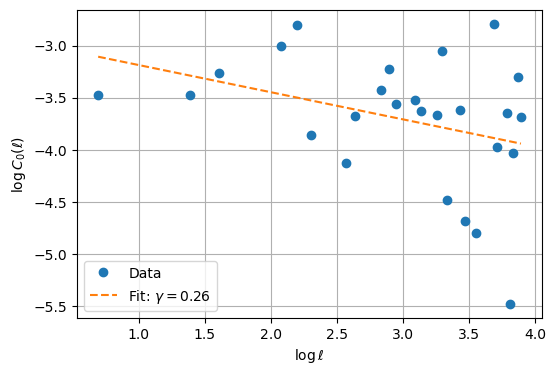

In [7]:
plt.figure(figsize=(6,4))
plt.plot(log_l, log_C0, 'o', label="Data")
plt.plot(log_l, intercept - gamma_hat * log_l, '--',
         label=rf"Fit: $\gamma={gamma_hat:.2f}$")
plt.xlabel(r"$\log \ell$")
plt.ylabel(r"$\log C_0(\ell)$")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
df

,t,spread,volume,sign,price,t_bin
0,0.000202,0.1100,8.0,-1,100.000,0.00
1,0.001070,0.1030,NaN,1,99.984,0.00
2,0.001496,0.1015,NaN,-1,100.029,0.00
3,0.003336,0.0920,NaN,1,99.979,0.00
4,0.003952,0.1106,NaN,1,100.060,0.00
...,...,...,...,...,...,...
996,0.981441,0.0834,79.0,1,101.070,0.98
997,0.981875,0.1010,NaN,-1,101.120,0.98
998,0.986784,0.1007,NaN,-1,100.998,0.98
999,0.991232,0.1153,3.0,-1,100.958,0.99


Estimated H (price, method of moments): H = 0.455


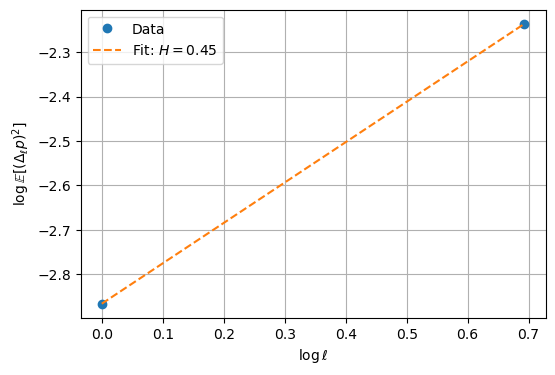

In [9]:
import numpy as np
import matplotlib.pyplot as plt


# --- 1. Prix à pas de temps constant ---
p = df_grouped["price"].to_numpy()
N = len(p)

# --- 2. Paramètres ---
L_max = 2  # petits lags, robuste
lags = np.arange(1, L_max + 1)

# --- 3. Moment d'ordre 2 ---
m2 = np.zeros(L_max)

for i, l in enumerate(lags):
    increments = p[l:] - p[:-l]
    m2[i] = np.mean(increments**2)

# --- 4. Régression log–log ---
log_l = np.log(lags)
log_m2 = np.log(m2)

coeffs = np.polyfit(log_l, log_m2, 1)
slope = coeffs[0]
H_hat = slope / 2

print(f"Estimated H (price, method of moments): H = {H_hat:.3f}")

# --- 5. Plot ---
plt.figure(figsize=(6,4))
plt.plot(log_l, log_m2, 'o', label="Data")
plt.plot(log_l, slope * log_l + coeffs[1], '--',
         label=rf"Fit: $H={H_hat:.2f}$")
plt.xlabel(r"$\log \ell$")
plt.ylabel(r"$\log \mathbb{{E}}[(\Delta_\ell p)^2]$")
plt.legend()
plt.grid(True)
plt.show()


$$\mathcal{G}(\ell) = -(2p-1)G(1)\lambda_\ell.$$

When $C(\ell) \stackrel{\ell \gg 1}{\sim} \ell^{-\gamma}$, one finds as expected $G(\ell) = G(1) + \sum_{n=1}^{\ell} \mathcal{G}(n) \stackrel{\ell \gg 1}{\sim} \ell^{-\beta}$ with $\beta = (1-\gamma)/2$ [9].

In [10]:
def Gs(l, p, G1, gamma):
    lambda_l = l**((gamma-3)/2)
    Gs_l = -(2*p-1)*G1*lambda_l
    return Gs_l

def estimate_p(tab_sign):
    same_sign = (tab_sign[1:]== tab_sign[:-1])
    p_hat = np.mean(same_sign)
    return p_hat

def G(G1, l, p, gamma):
    G_l = G1
    i = 1
    while i <= l:
        G_l += Gs(i, p, G1, gamma)
        i+=1
    return G_l


    
    


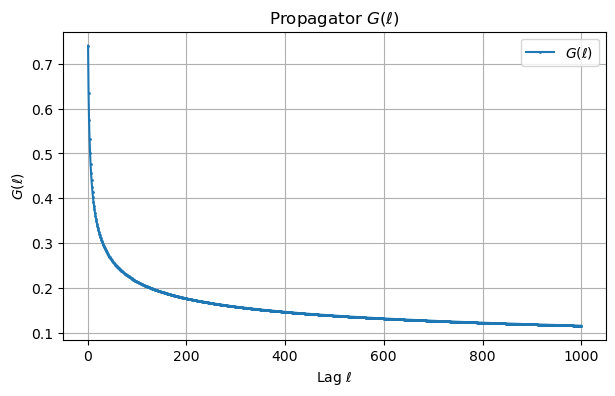

In [11]:
G1 = 1.0       
gamma = 0.3652812433996198 
p = 0.63

# --- lags ---
L_max = 1000
lags = np.arange(1, L_max + 1)

# --- calcul de G(l) ---
G_vals = np.array([G(G1, l, p, gamma) for l in lags])

# --- plot ---
plt.figure(figsize=(7,4))
plt.plot(lags, G_vals, 'o-',markersize=1, label=r"$G(\ell)$")

plt.xlabel(r"Lag $\ell$")
plt.ylabel(r"$G(\ell)$")
plt.title("Propagator $G(\\ell)$")
plt.grid(True)
plt.legend()
plt.show()

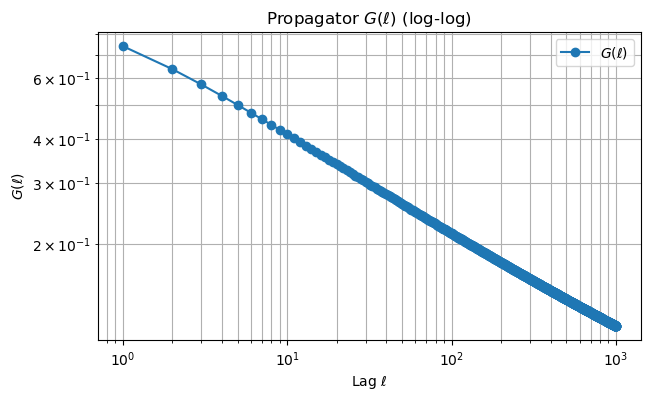

In [12]:
plt.figure(figsize=(7,4))
plt.loglog(lags, G_vals, 'o-', label=r"$G(\ell)$")

plt.xlabel(r"Lag $\ell$")
plt.ylabel(r"$G(\ell)$")
plt.title("Propagator $G(\\ell)$ (log-log)")
plt.grid(True, which="both")
plt.legend()
plt.show()

In [13]:
# --- choix de la zone asymptotique ---
l_min = 50 # à ajuster selon ton graphe (IMPORTANT)
mask = lags >= l_min

lags_reg = lags[mask]
G_reg = np.abs(G_vals[mask])

# --- régression log-log ---
log_l = np.log(lags_reg)
log_G = np.log(G_reg)

coeffs = np.polyfit(log_l, log_G, 1)
beta_hat = -coeffs[0]
intercept = coeffs[1]

print(f"Estimated beta = {beta_hat:.3f}")


Estimated beta = 0.267


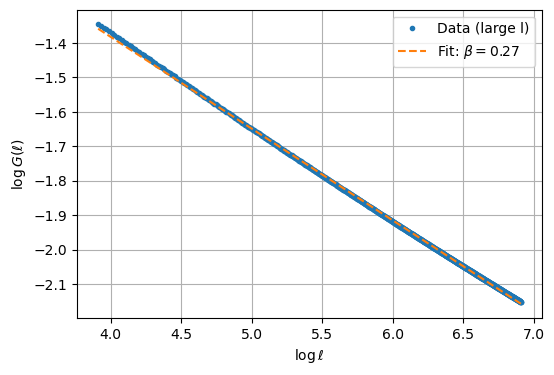

In [14]:
plt.figure(figsize=(6,4))
plt.plot(log_l, log_G, 'o',markersize=3, label="Data (large l)")
plt.plot(log_l, intercept - beta_hat * log_l, '--',
         label=rf"Fit: $\beta={beta_hat:.2f}$")
plt.xlabel(r"$\log \ell$")
plt.ylabel(r"$\log G(\ell)$")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
df_grouped

,t_bin,spread,volume,sign,price
0,0.00,0.0969,32.0,1,99.989
1,0.01,0.1062,8.0,1,100.022
2,0.02,0.1133,141.0,-1,99.890
3,0.03,0.1016,121.0,1,99.522
4,0.04,0.1102,52.0,-1,99.232
...,...,...,...,...,...
95,0.95,0.0884,213.0,-1,100.887
96,0.96,0.1105,150.0,-1,101.184
97,0.97,0.0930,17.0,1,101.000
98,0.98,0.1007,79.0,-1,100.998


In [16]:
df_TD4

,transaction date (1=1day=24 hours),bid-ask spread,volume of the transaction (if known),Sign of the transaction,Price (before transaction)
0,0.000202,0.1100,8.0,-1,100.000
1,0.001070,0.1030,NaN,1,99.984
2,0.001496,0.1015,NaN,-1,100.029
3,0.003336,0.0920,NaN,1,99.979
4,0.003952,0.1106,NaN,1,100.060
...,...,...,...,...,...
996,0.981441,0.0834,79.0,1,101.070
997,0.981875,0.1010,NaN,-1,101.120
998,0.986784,0.1007,NaN,-1,100.998
999,0.991232,0.1153,3.0,-1,100.958
